In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import contour_conversion.image_conversion as cp
import time

from numba import jit

import shapely.affinity as sa

import fill_strategy.zigzag as ZZ

In [2]:
image = cv2.imread("../images/gears.png", 0)
not image is None

True

In [3]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString

In [4]:
def plot_path(path):
    
    X = []
    Y = []
    for p in list(path):
        X.append(p[0])
        Y.append(p[1])

    plt.plot(X,Y)

In [5]:
%reload_ext autoreload
%autoreload 2

p_list = cp.execute(image)

In [7]:
%%time

path = ZZ.execute(p_list, 5)

INFO:Polygon: 0: 3.70485520362854
INFO:Polygon: 1: 0.003277301788330078
INFO:Polygon: 2: 0.003751993179321289
INFO:TOTAL TIME: 3.713782787322998


CPU times: user 3.71 s, sys: 8.21 ms, total: 3.72 s
Wall time: 3.71 s


In [8]:

'''
Get the neighbor indices
'''
def neighbors(i1, length):
    
    i0 = i1-1 if i1 != 0 else length-1
    i2 = i1+1 if i1+1 != length else 0

    return i0,i1,i2


'''
Calculate metrics of path
'''
def metrics(path):      
    
    sharpness = 0

    for i1 in range(len(path)):
        
        i0,i1,i2 = neighbors(i1, len(path))
        
        p0 = path[i0]
        p1 = path[i1]
        p2 = path[i2]
                
        a0 = np.arctan2(p1[1]-p0[1], p1[0]-p0[0])
        a2 = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])

        # get the angle change
        da = a2-a0
        
        sharpness += abs(da)
        
    return sharpness
    
    

In [9]:
m = []

for p in path[0]:
    
    m.append(metrics(p)/len(p))
    
np.average(m)

1.7812504798115991

<IPython.core.display.Javascript object>


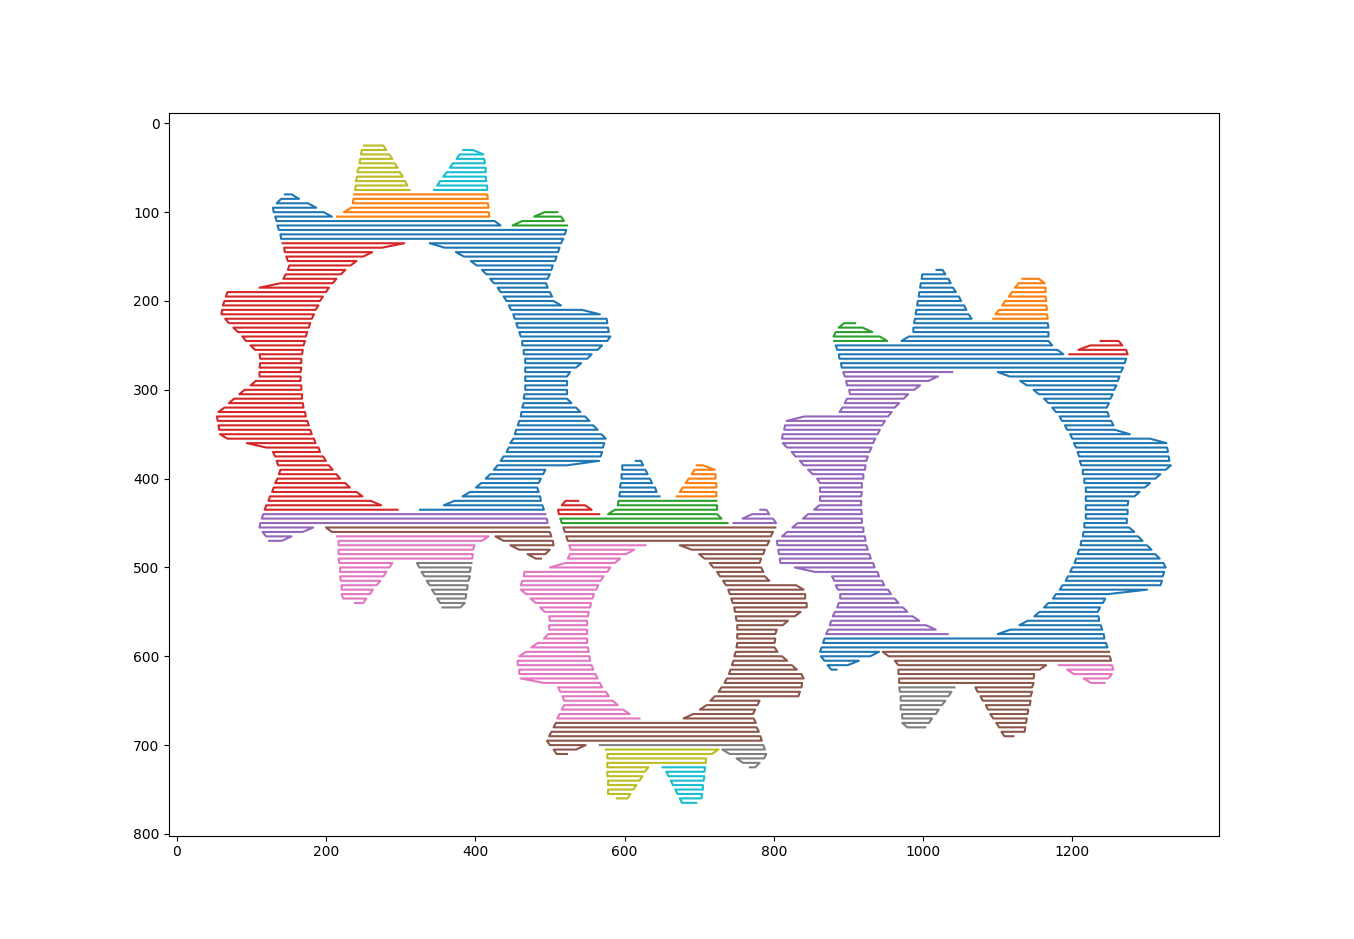

In [10]:
%matplotlib notebook

for obj in path:
    for p in obj:
        plot_path(p)
    
plt.gca().invert_yaxis()

In [11]:
from gcode import GcodeWriter

In [14]:
result = GcodeWriter(filename='penguin.gcode', scale = 0.1)

In [16]:
_ = result.convert(path[0])

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))